# EDA on the API retrieved data about Manga Titles.

In [1]:
# Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import re
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import string
import random

pd.set_option('display.max_columns', None)

In [2]:
# Import dataframe from out_data.csv .
data = pd.read_csv('out_data.csv')

In [3]:
# Save a copy of the original data for genres analysis.
df = data.copy()

### Exploring the distribution of genres in our data.

In [4]:
# Explode genres list for each Manga.
df['genres'] = df['genres'].apply(literal_eval)
df = df.explode('genres')

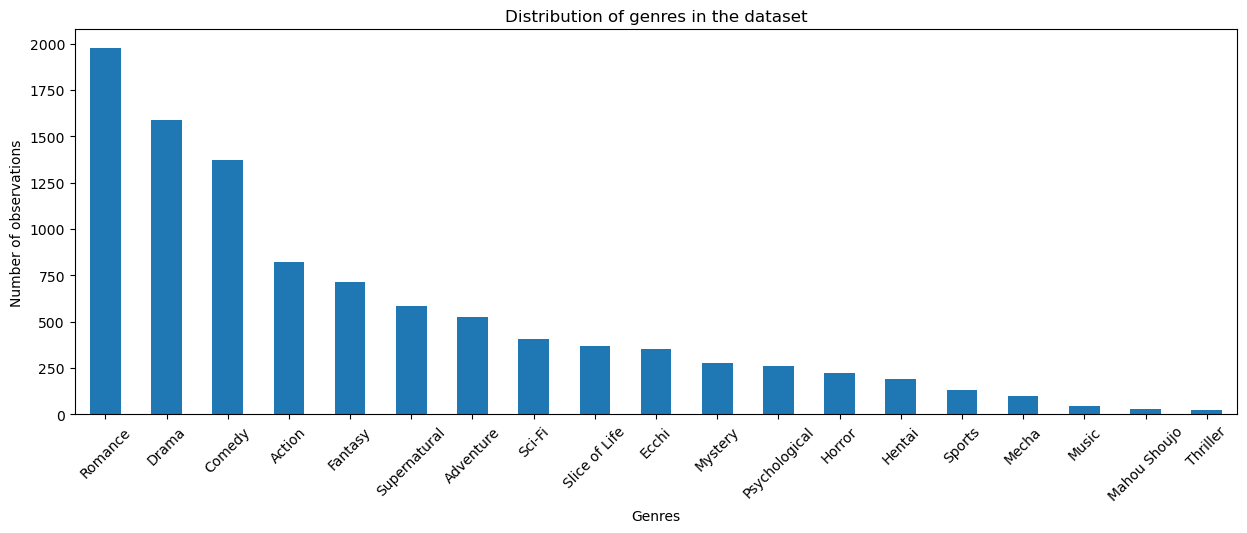

In [5]:
# Plot the distribution of genres in the dataset.
df['genres'].value_counts().plot.bar(x = 'genres',
                                     y ='count',
                                     figsize = (15,5),
                                     title = 'Distribution of genres in the dataset',
                                     xlabel = 'Genres',
                                     ylabel = 'Number of observations',
                                     rot = 45)
None

### Manga description — word count distribution.

In [6]:
# Calculating the word count for book description.
data['word_count'] = data['description'].apply(lambda x: len(str(x).split()))

<Figure size 500x500 with 0 Axes>

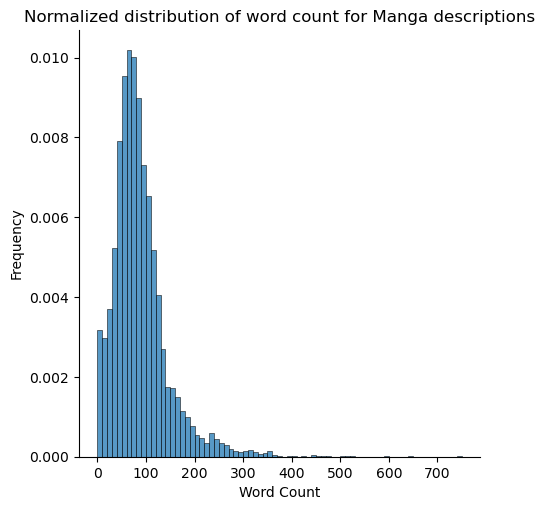

In [7]:
# Plot the word count distribution.
plt.figure(figsize = [5,5])
ax = sns.displot(data, x = 'word_count', binwidth = 10, stat = 'density')
ax.set(title = 'Normalized distribution of word count for Manga descriptions',
      xlabel = 'Word Count',
      ylabel = 'Frequency')
plt.show()

### Clean the description column for futher analysis.

In [8]:
# Number of titles without a description.
data['description'].isna().sum()

10

In [9]:
# Drop titles with NaN values in the description column.
data.dropna(subset = ['description'], inplace = True)

In [10]:
# Reset dataframe's index.
data.reset_index(drop = True, inplace = True)

In [11]:
# Remove the "Source Info" from the description column entries
data['description'] = data['description'].str.replace(r'Source.*' , '', regex = True)

In [12]:
# Check result
data['description'][5]

'Young Mitsuki loves singing and dreams of becoming a pop star. Unfortunately, a malignant tumor in her throat prevents her from pursuing her passion. However, her life turns around when two surprisingly fun-loving harbingers of death appear to grant Mitsuki a temporary reprieve from her illness and give her singing career a magical push start.<br><br>\n(\nChapter count contains the oneshot Ginyuu Meika (2nd volume); also includes all interlude and 4-koma chapters of the retail volumes. '

### Define functions for futher text cleaning.

In [13]:
def removeNonAscii(s):
    """ function to remove non ASCII characters """
    return "".join(i for i in s if  ord(i)<128)

def lower_case(text):
    """ function to convert all string characters to lowercase characters """
    return text.lower()

def remove_parenthesis_content(text):
    """ function to remove parentheses and content inside """
    parent_pattern = re.compile('\(.*\)')
    return parent_pattern.sub(r'', text)
    
def remove_stop_words(text):
    """ function to remove stop words from the text """
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    return  " ".join(text)

def remove_punctuation(text):
    """ function to remove special characters: punctuation """
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    return " ".join(text)

#Function for removing the html tags
def remove_html(text):
    """ function to remove special characters: html tags """
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


In [22]:
# Applying all the functions in description and storing as a cleaned_desc
data['cleaned_description'] = data['description'].apply(removeNonAscii)
data['cleaned_description'] = data['cleaned_description'].apply(lower_case)
data['cleaned_description'] = data['cleaned_description'].apply(remove_stop_words)
data['cleaned_description'] = data['cleaned_description'].apply(remove_parenthesis_content)
data['cleaned_description'] = data['cleaned_description'].apply(remove_html)
data['cleaned_description'] = data['cleaned_description'].apply(remove_punctuation)

In [25]:
data['description'][20]

'Years ago, Genma promised his old friend Soun Tendo that Ranma would marry one of Soun’s three daughters and carry on the family’s martial arts school. Except that the girl picked to be Ranma’s bride doesn’t seem to like him, Ranma keeps getting into fights…and did we mention that whole changing into a girl thing?\n<br><br>\n('

In [26]:
data['cleaned_description'][20]

'years ago genma promised old friend soun tendo ranma would marry one souns three daughters carry familys martial arts school except girl picked ranmas bride doesnt seem like him ranma keeps getting fightsand mention whole changing girl thing'

## Bigram distribution for the Manga description.

In [17]:
# Converting text descriptions into vectors using TF-IDF.
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(data['cleaned_description'])
total_words = tfidf_matrix.sum(axis=0) 

# Finding the word frequency.
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

# Converting into bigram dataframe.
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

# Taking first 20 records.
bigram = bigram.head(20)

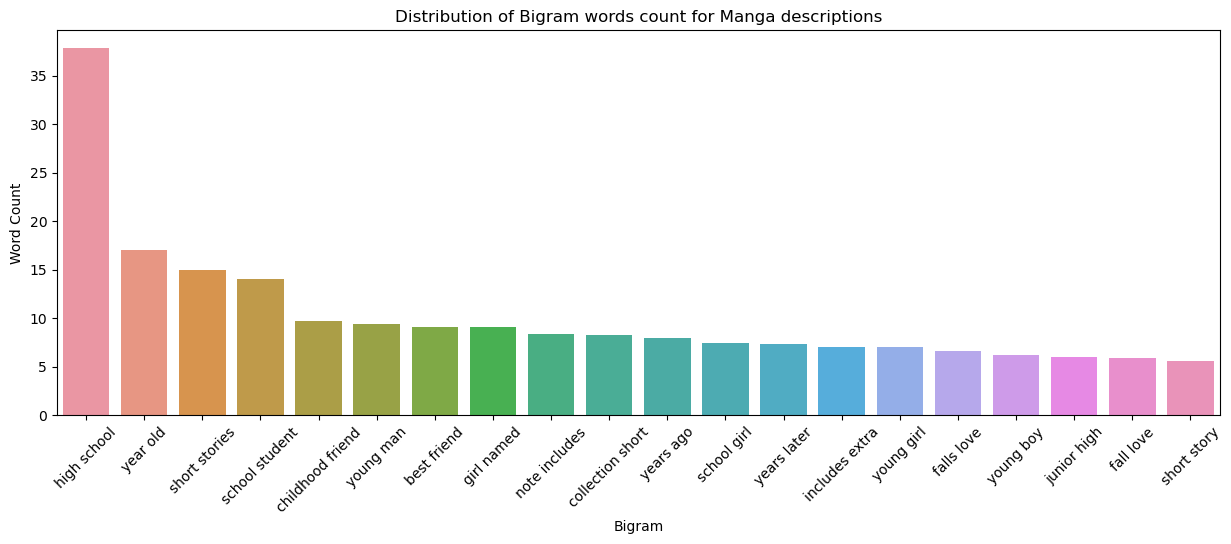

In [18]:
# Plot the Bigram disribution for the top 20 words in the Manga description.
plt.figure(figsize = [15,5])
ax = sns.barplot( x = bigram['bigram'], y=bigram['count'])
ax.set(title = 'Distribution of Bigram words count for Manga descriptions',
      xlabel = 'Bigram',
      ylabel = 'Word Count')
plt.xticks(rotation = 45)
plt.show()

## Trigram distribution for the book description

In [19]:
# Converting text descriptions into vectors using TF-IDF 
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(data['cleaned_description'])
total_words = tfidf_matrix.sum(axis=0) 

# Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

# converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 

# Taking first 20 records
trigram = trigram.head(20)

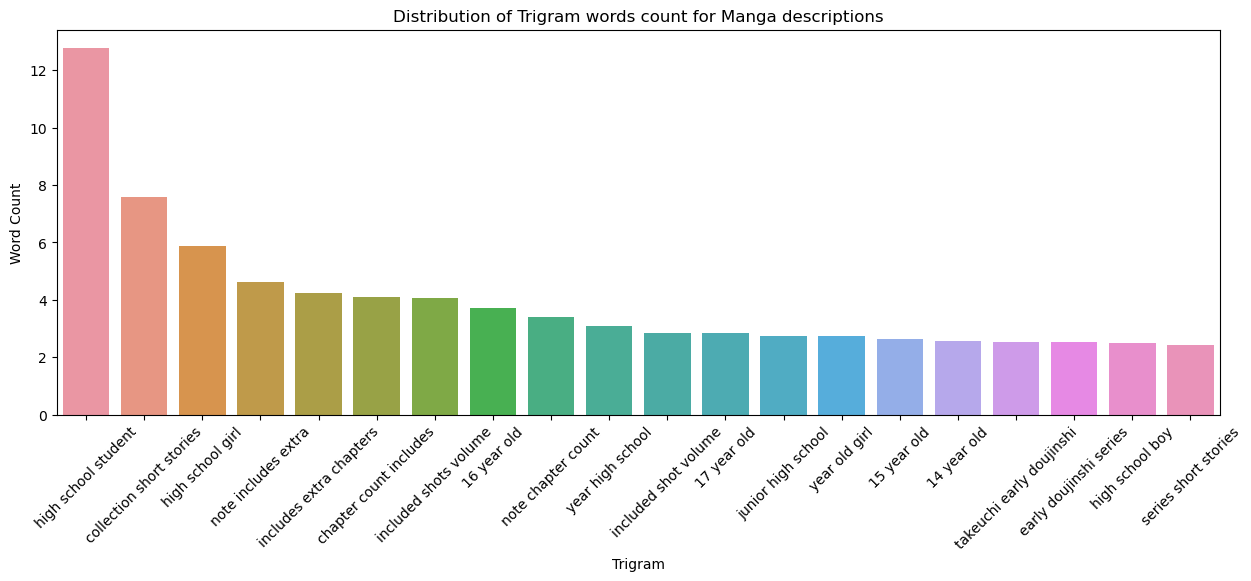

In [20]:
# Plot the Trigram disribution for the top 20 words in the Manga description.
plt.figure(figsize = [15,5])
ax = sns.barplot(x = trigram['trigram'], y=trigram['count'])
ax.set(title = 'Distribution of Trigram words count for Manga descriptions',
      xlabel = 'Trigram',
      ylabel = 'Word Count')
plt.xticks(rotation = 45)
plt.show()

In [21]:
# Observations : descriptions are reduced from source(API)
# Need to remove patterns such as Chapter Info, Includes... extra shots ... for better analysis

## Export resulting dataset as 'cleaned_out_data.csv'

In [27]:
data.to_csv('cleaned_out_data.csv', index = False)